In [1]:
import os
from pathlib import Path

repo_root = Path.cwd()
while repo_root != repo_root.parent and not (repo_root / ".git").exists():
    repo_root = repo_root.parent
os.chdir(repo_root)
print(f"Running analysis notebook from {repo_root}")

Running analysis notebook from c:\Users\Aakil\Documents\GitHub\Data-cleanup-and-insights-portfolio


## 1. Load raw sales data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("ggplot")

DATA_DIR = Path("02-clean-plus-insight-pack")
RAW_PATH = DATA_DIR / "raw_sales.csv"
CLEAN_PATH = DATA_DIR / "cleaned_sales.csv"

df = pd.read_csv(RAW_PATH)
raw_rows = len(df)
df.head()

,order_id,order_date,customer_id,country,product_category,unit_price,quantity,discount_percent,payment_method,returned
0,ORD1001,2023-01-02,CUST005,Netherlands,Electronics,249.99,1,10,Credit Card,no
1,ORD1002,2023-01-03,CUST012,NL,Clothing,79.50,2,5,PayPal,no
2,ORD1003,2023-01-05,CUST018,nl,Home,120.00,1,0,Credit Card,yes
3,ORD1004,2023-01-07,CUST021,Netherlands,Beauty,45.00,3,15,iDEAL,no
4,ORD1005,2023-01-09,CUST030,NL,Electronics,0.00,1,5,Credit Card,no


In [4]:
df.info()
df.describe(include=["number"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          50 non-null     object 
 1   order_date        49 non-null     object 
 2   customer_id       50 non-null     object 
 3   country           50 non-null     object 
 4   product_category  50 non-null     object 
 5   unit_price        50 non-null     float64
 6   quantity          50 non-null     int64  
 7   discount_percent  50 non-null     int64  
 8   payment_method    50 non-null     object 
 9   returned          49 non-null     object 
dtypes: float64(1), int64(2), object(7)
memory usage: 4.0+ KB


,unit_price,quantity,discount_percent
count,50.000000,50.000000,50.000000
mean,178.799400,1.520000,10.340000
std,140.157465,0.735125,15.772114
min,-15.000000,1.000000,0.000000
25%,71.250000,1.000000,0.000000
50%,139.000000,1.000000,5.000000
75%,268.747500,2.000000,12.000000
max,520.000000,4.000000,80.000000


## 2. Issues spotted in the raw file
- Mixed date formats and a few missing order dates.
- Negative/zero unit prices plus quantities that should be integers.
- Discount percentages that shoot past 70%.
- Duplicate order IDs, inconsistent country labels, and mixed-case product text.
- Return flags sometimes blank, so we'll keep them but not rely on them.

In [5]:
df = df.dropna(how="all").copy()

text_columns = ["order_id", "customer_id", "country", "product_category", "payment_method", "returned"]
for column in text_columns:
    df[column] = df[column].astype("string").str.strip()

df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")

numeric_columns = ["unit_price", "quantity", "discount_percent"]
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors="coerce")

def normalize_country(value):
    if pd.isna(value):
        return pd.NA
    token = str(value).strip().lower()
    lookup = {
        "nl": "Netherlands",
        "netherlands": "Netherlands",
        "nederland": "Netherlands",
        "belgium": "Belgium",
        "be": "Belgium",
        "germany": "Germany",
        "de": "Germany",
        "france": "France",
        "fr": "France"
    }
    return lookup.get(token, token.title())

df["country"] = df["country"].apply(normalize_country)

df["discount_percent"] = df["discount_percent"].fillna(0)
df["discount_percent"] = df["discount_percent"].clip(lower=0, upper=60)

df = df[df["unit_price"] > 0]
df = df[df["quantity"] > 0]
df["quantity"] = df["quantity"].astype("Int64")

df = df.dropna(subset=["order_id", "order_date", "customer_id"])
df = df.sort_values("order_date").drop_duplicates(subset="order_id", keep="first")

df["revenue"] = df["unit_price"] * df["quantity"] * (1 - df["discount_percent"] / 100)
df["revenue"] = df["revenue"].round(2)
df["order_month"] = df["order_date"].dt.to_period("M").astype(str)

clean_rows = len(df)
print(f"Rows kept: {clean_rows} of {raw_rows}")

Rows kept: 44 of 50


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 0 to 49
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          44 non-null     string        
 1   order_date        44 non-null     datetime64[ns]
 2   customer_id       44 non-null     string        
 3   country           44 non-null     object        
 4   product_category  44 non-null     string        
 5   unit_price        44 non-null     float64       
 6   quantity          44 non-null     Int64         
 7   discount_percent  44 non-null     int64         
 8   payment_method    44 non-null     string        
 9   returned          43 non-null     string        
 10  revenue           44 non-null     Float64       
 11  order_month       44 non-null     object        
dtypes: Float64(1), Int64(1), datetime64[ns](1), float64(1), int64(1), object(2), string(5)
memory usage: 4.6+ KB


In [7]:
df.to_csv(CLEAN_PATH, index=False)
print(f"Clean file saved to {CLEAN_PATH}")

Clean file saved to 02-clean-plus-insight-pack\cleaned_sales.csv


## 3. Core metrics

In [8]:
total_revenue = df["revenue"].sum().round(2)
order_count = len(df)
avg_order_value = (total_revenue / order_count).round(2)

metrics = pd.Series({
    "Total revenue (EUR)": total_revenue,
    "Number of orders": order_count,
    "Average order value (EUR)": avg_order_value,
})
metrics

Total revenue (EUR)          8264.58
Number of orders               44.00
Average order value (EUR)     187.83
dtype: float64

In [9]:
monthly_revenue = df.groupby("order_month")["revenue"].sum().sort_index()
country_revenue = df.groupby("country")["revenue"].sum().sort_values(ascending=False)
category_revenue = df.groupby("product_category")["revenue"].sum().sort_values(ascending=False)

monthly_revenue
country_revenue
category_revenue

product_category
Electronics    3727.94
Home            1813.6
Clothing       1182.49
Sports           597.5
Beauty          547.05
Outdoors         321.0
Kids              75.0
Name: revenue, dtype: Float64

## 4. Visualise revenue trends

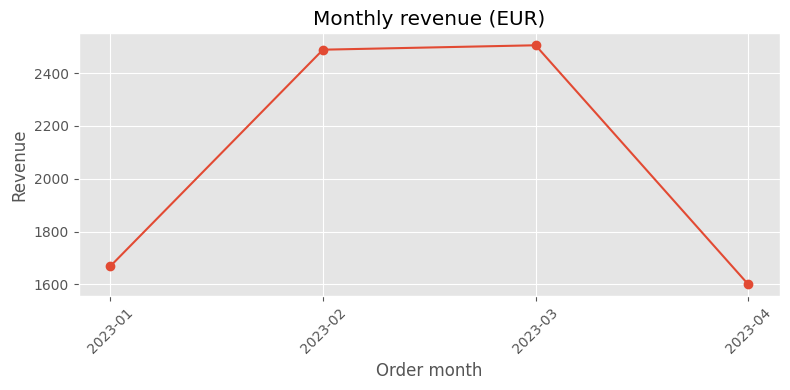

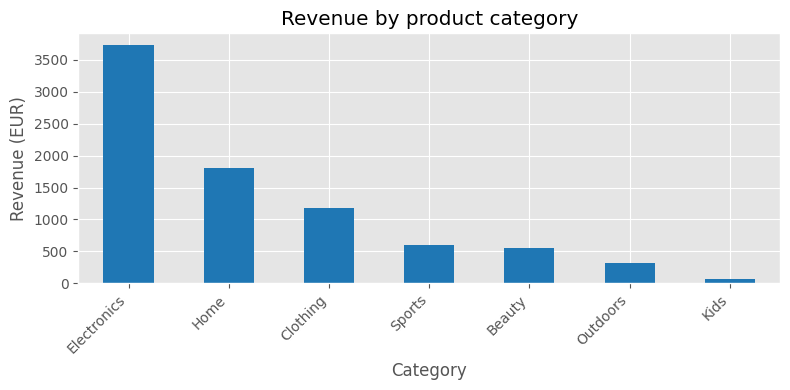

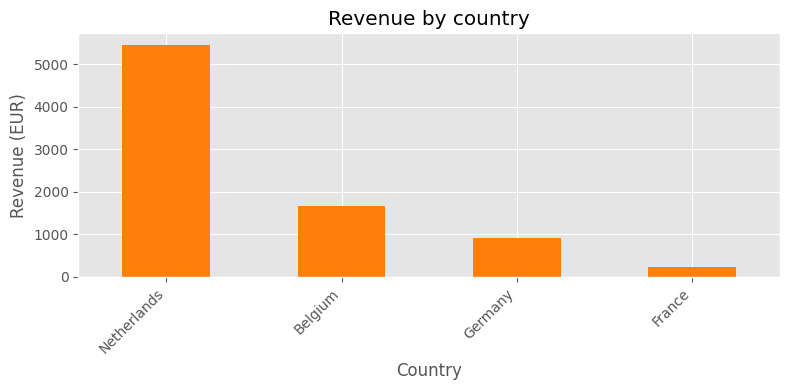

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(monthly_revenue.index, monthly_revenue.values, marker="o")
ax.set_title("Monthly revenue (EUR)")
ax.set_xlabel("Order month")
ax.set_ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
category_revenue.plot(kind="bar", ax=ax, color="#1f77b4")
ax.set_title("Revenue by product category")
ax.set_xlabel("Category")
ax.set_ylabel("Revenue (EUR)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
country_revenue.plot(kind="bar", ax=ax, color="#ff7f0e")
ax.set_title("Revenue by country")
ax.set_xlabel("Country")
ax.set_ylabel("Revenue (EUR)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Insights recap**
- Electronics is the runaway leader, with Home and Clothing following as secondary revenue streams.
- The Netherlands drives the majority of sales, with Belgium and Germany providing meaningful secondary volume.
- Revenue climbs steadily from January through March and levels off slightly in April, suggesting a healthy upward momentum to monitor in future months.